# CNN Practical: Inelastic Neutron Scattering

Inelastic neutron scattering (INS) can be used to infer information about the forces present in a material. Neutrons scatter off a sample, exchanging energy with certain fundamental vibrational modes of the sample. These vibraional modes include phonons (interatomic boding forces) and magnons (spin coupling between magnetic nuclei). 

[Johnstone et al. (2012)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.109.237202) have simulated magnon spectra from a double perovskite systems, where INS was used to distinguish between two possible magnetic Hamiltonians of the system. For this practical, we have simulated datasets for each of the possible Hamiltonians. We are going to train a CNN to classify the system correctly.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow v2.3.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. To access the data, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will take no effect.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    data_path = './sciml-workshop-data'

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# The dataset

We have already split the data into training and validation sets and saved them into two HDF5 files, `ins/train.h5` and `ins/test.h5`, containing respectively 20,000 and 6,676 INS images and their one-hot encoded labels identifying an image as either being of the *Dimer* or *Goodenough* Hamiltonian. 

### The `tf.data.Dataset` class
The number of images is so large that we may not be able to simultaneously load the whole dataset into memory on a small machine. To solve this issue, we will use [tensorflow.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to create an interface pointing to the files, which can load the data from disk on the fly when they are actually required.

In [4]:
# define image size
IMG_HEIGHT = 20
IMG_WIDTH = 200
N_CHANNELS = 1
N_CLASSES = 2

# generator
def hdf5_generator(path, buffer_size=32):
    """ Load data INS data from disk
    
    Args:
        path: path of the HDF5 file on disk
        buffer_size: number of images to read from disk
    """
    with h5py.File(path, 'r') as handle:
        n_samples, h, w, c = handle['images'].shape
        for i in range(0, n_samples, buffer_size):
            images = handle['images'][i:i+buffer_size, ..., :1]
            labels = handle['labels'][i:i+buffer_size]
            yield images, labels

# training data
train_dataset = tf.data.Dataset.from_generator(lambda: hdf5_generator(path=data_path + '/ins/train.h5'), 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), 
                                                              (None, N_CLASSES,)))

# test data
test_dataset = tf.data.Dataset.from_generator(lambda: hdf5_generator(path=data_path + '/ins/test.h5'), 
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), 
                                                             (None, N_CLASSES,)))
# print
print(train_dataset)
print(test_dataset)

<FlatMapDataset shapes: ((None, 20, 200, 1), (None, 2)), types: (tf.float32, tf.float32)>
<FlatMapDataset shapes: ((None, 20, 200, 1), (None, 2)), types: (tf.float32, tf.float32)>


### Load and use data

In the following cell, we will load the first buffer (with 32 data by default) to memory and plot some images and labels from it:

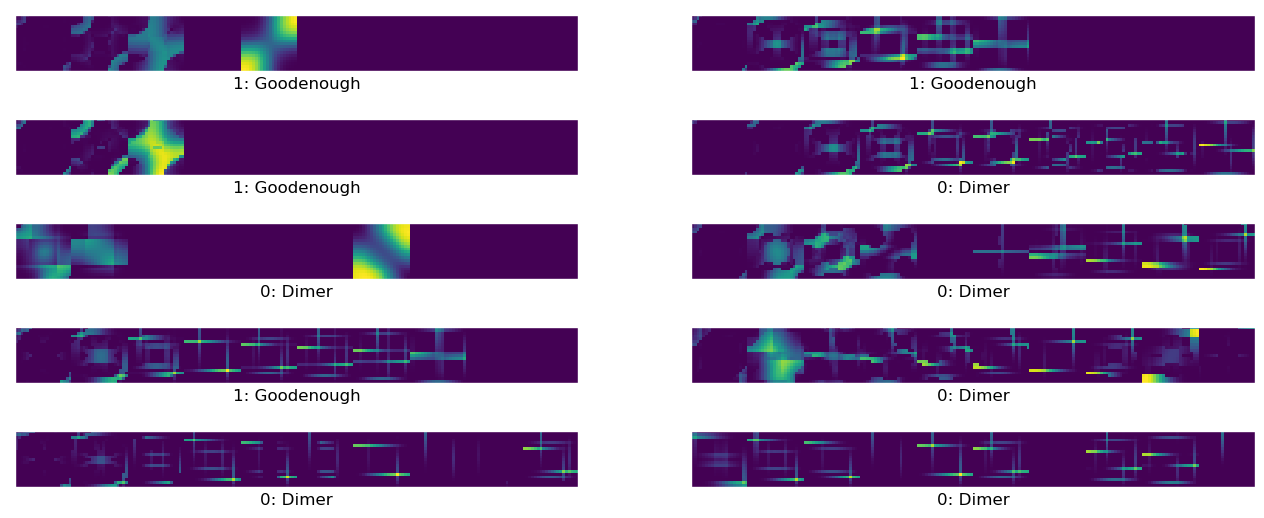

In [5]:
# load the first buffer (with 32 data by default)
images, labels = list(test_dataset.take(1))[0]

# plot some images and labels from it
nplot = 10
fig, axes = plt.subplots(nplot // 2, 2, figsize=(16, nplot / 1.5), dpi=100)
for ax, image, label in zip(axes.flatten(), images, labels):
    ax.matshow(np.squeeze(image))
    ax.set_xlabel('0: Dimer' if label[0] < .5 else '1: Goodenough', c='k')
    ax.set_xticks([])
    ax.set_yticks([])

---

# Classification by CNN

The task is to build and train a CNN to solve this binary classification problem. 

## 1. Network architecture

First, design the network architecture. Note that the image height is quite small, so we need to preserve the image size by passing `padding='same'` to `Conv2D`. A suggested architecture is provided:

- Conv2D
 - 8 filters
 - kernel size 5$\times$5
 - ReLU activation
- MaxPool2D 
- BatchNormalization
- Conv2D 
 - 16 filters
 - kernel size 3$\times$3
 - ReLU activation
- MaxPool2D
- BatchNormalization
- Conv2D 
 - 16 filters
 - kernel size 3$\times$3
 - ReLU activation
- MaxPool2D
- BatchNormalization
- Flatten 
- Dense
 - 16 units
 - ReLU activation
- Dense
 - 8 units
 - ReLU activation
- Dense
 - 1 unit
 - sigmoid activation


     
     
**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# network architecture
model = Sequential()
model.add(Conv2D(8, kernel_size=(5, 5), activation='relu', padding='same',
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(N_CLASSES, activation='sigmoid'))

# print summary
model.summary()
```
    
</p>
</details>


In [6]:
# network architecture
model = Sequential()
model.add(Conv2D(8, kernel_size=(5, 5), activation='relu', padding='same',
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(N_CLASSES, activation='sigmoid'))

# print summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 200, 8)        208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 100, 8)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 100, 8)        32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 100, 16)       1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 50, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 50, 16)         64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 50, 16)         2

## 2.  Compile the model

We can add the following metrics to see how the network performs for the two classes:

* `TruePositives`: number of right predictions for Dimer
* `FalsePositives`: number of wrong predictions for Dimer
* `TrueNegatives`: number of right predictions for Goodenough
* `FalseNegatives`: number of wrong predictions for Goodenough

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics= ['accuracy',
                        keras.metrics.TruePositives(name='true_positives'),
                        keras.metrics.FalsePositives(name='false_positives'),
                        keras.metrics.TrueNegatives(name='true_negatives'),
                        keras.metrics.FalseNegatives(name='false_negatives')])
```
    
</p>
</details>


In [7]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics= ['accuracy',
                        keras.metrics.TruePositives(name='true_positives'),
                        keras.metrics.FalsePositives(name='false_positives'),
                        keras.metrics.TrueNegatives(name='true_negatives'),
                        keras.metrics.FalseNegatives(name='false_negatives')])

## 3. Train the model

Using the suggested architecture, we can achieve an accuracy greater than 95% with 2 epochs. 

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# train the model
training_history = model.fit(train_dataset, validation_data=test_dataset, 
                             epochs=2, batch_size=32)
    
# print final values of metrics for validation data
print('Right for Tetragonal: %d' % training_history.history['val_true_positives'][-1])
print('Wrong for Tetragonal: %d' % training_history.history['val_false_positives'][-1])
print('Right for Monoclinic: %d' % training_history.history['val_true_negatives'][-1])
print('Wrong for Monoclinic: %d' % training_history.history['val_false_negatives'][-1])
```
    
</p>
</details>

In [8]:
# train the model
training_history = model.fit(train_dataset, validation_data=test_dataset, 
                             epochs=2, batch_size=32)

Epoch 1/2
625/625 [==============================] - 46s 73ms/step - loss: 0.2929 - accuracy: 0.8636 - true_positives: 17263.0000 - false_positives: 2726.0000 - true_negatives: 17274.0000 - false_negatives: 2737.0000 - val_loss: 0.4388 - val_accuracy: 0.8304 - val_true_positives: 5538.0000 - val_false_positives: 1127.0000 - val_true_negatives: 5549.0000 - val_false_negatives: 1138.0000
Epoch 2/2
625/625 [==============================] - 52s 84ms/step - loss: 0.1045 - accuracy: 0.9579 - true_positives: 19176.0000 - false_positives: 866.0000 - true_negatives: 19134.0000 - false_negatives: 824.0000 - val_loss: 0.1138 - val_accuracy: 0.9545 - val_true_positives: 6374.0000 - val_false_positives: 301.0000 - val_true_negatives: 6375.0000 - val_false_negatives: 302.0000


In [9]:
# print final values of metrics for validation data
print('Right for Dimer: %d' % training_history.history['val_true_positives'][-1])
print('Wrong for Dimer: %d' % training_history.history['val_false_positives'][-1])
print('Right for Goodenough: %d' % training_history.history['val_true_negatives'][-1])
print('Wrong for Goodenough: %d' % training_history.history['val_false_negatives'][-1])

Right for Dimer: 6374
Wrong for Dimer: 301
Right for Goodenough: 6375
Wrong for Goodenough: 302
